In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.cluster import DBSCAN
from tqdm import tqdm

In [2]:
path = "DAS_data/"
images = []
target_shape = (585, 153)
for file in tqdm(os.listdir(path)):
    img = np.load(os.path.join(path, file))
    h, w = img.shape[:2]
    target_h, target_w = target_shape

    crop_h = min(h, target_h)
    crop_w = min(w, target_w)
    img_cropped = img[:crop_h, :crop_w]
    images.append(img_cropped)

stacked = np.stack(images, axis=0)



100%|██████████████████████████████████████| 2334/2334 [00:10<00:00, 217.48it/s]


In [3]:
print(stacked.shape)
mu = stacked.mean(axis = 0)
print(mu.shape)
var = stacked.var(axis = 0)
print(var.shape)

(2334, 585, 153)
(585, 153)
(585, 153)


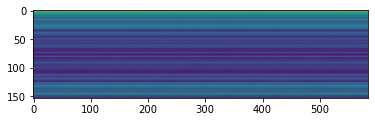

In [4]:
plt.imshow(mu.T)

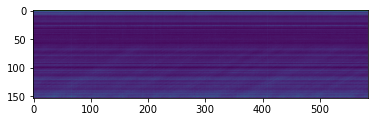

In [5]:
plt.imshow(var.T)

In [6]:
def normalize(a):
    a = (a - np.min(a))/(np.max(a) - np.min(a))
    return a

def detected_lines(path):
    orig_img = np.load(path).T
    img = normalize(orig_img)
    img[img<0.5] = 0
    img = (255*np.stack([img]*3, axis=-1)).astype(np.uint8)
    # Load and process image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)

    # Get (x, y) coordinates of all edge pixels
    points = np.column_stack(np.where(edges > 0))  # (y, x)
    points = points[:, ::-1]  # convert to (x, y)

    # Use DBSCAN to cluster edge points
    db = DBSCAN(eps=10, min_samples=20).fit(points)
    labels = db.labels_

    # For visualization
    result = img.copy()
    unique_labels = set(labels)
    lines = []
    for label in unique_labels:
        if label == -1:
            continue  # noise

        cluster_points = points[labels == label]
        x = cluster_points[:, 0]
        y = cluster_points[:, 1]

        if len(x) < 10:
            continue

        # Fit least squares line: y = mx + b
        A = np.vstack([x, np.ones(len(x))]).T
        m, b = np.linalg.lstsq(A, y, rcond=None)[0]

        # Filter only diagonal-ish lines
        if abs(m) < 0.2:
            continue

        # Start/end points for drawing
        x_start, x_end = np.min(x), np.max(x)
        y_start = int(m * x_start + b)
        y_end = int(m * x_end + b)

        cv2.line(result, (x_start, y_start), (x_end, y_end), (0, 0, 255), 2)
        lines.append([m, x_start, y_start, x_end, y_end])
    return lines

In [7]:
lines = []
for file in tqdm(os.listdir(path)):
    file = os.path.join(path, file)
    info = detected_lines(file)
    lines.extend(info)

100%|███████████████████████████████████████| 2334/2334 [03:42<00:00, 10.48it/s]


In [8]:
len(lines)

3015

In [9]:
lines = np.asarray(lines)
print(lines.shape)
print(lines)

(3015, 5)
[[-4.58563536e-01  5.58000000e+02  4.10000000e+01  5.63000000e+02
   3.80000000e+01]
 [-5.68923630e-01  3.67000000e+02  1.57000000e+02  5.35000000e+02
   6.20000000e+01]
 [-5.99489106e-01  4.32000000e+02  1.55000000e+02  5.84000000e+02
   6.40000000e+01]
 ...
 [-6.45989247e-01  1.45000000e+02  1.54000000e+02  2.82000000e+02
   6.60000000e+01]
 [ 3.12838981e-01  2.71000000e+02  1.37000000e+02  2.98000000e+02
   1.45000000e+02]
 [ 5.58603180e-01  2.34000000e+02  1.25000000e+02  2.62000000e+02
   1.41000000e+02]]


In [10]:
slopes = lines[:, 0]
print(slopes)
avg_slope = np.abs(slopes).mean()
print(avg_slope)
var_slope = np.abs(slopes).var()
print(var_slope)
slope_pos_prob = np.mean(slopes>0)
print(slope_pos_prob)

[-0.45856354 -0.56892363 -0.59948911 ... -0.64598925  0.31283898
  0.55860318]
0.5253884980662408
0.12718836844322423
0.24344941956882254


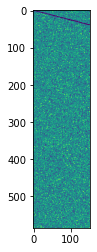

In [126]:
plt.imshow(syn_img)

-0.44742436182087963
497


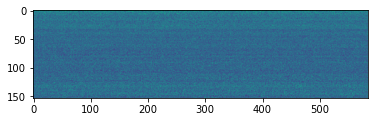

In [113]:
syn_img = np.random.randn(*target_shape)
syn_img = syn_img * np.sqrt(var) + mu
plt.imshow(normalize(syn_img.T))
slope = -np.random.randn(1)[0] * var_slope - avg_slope
print(slope)
#rand = np.random.rand(1)[0]
#if rand > slope_pos_prob:
#    slope = -slope
start_x = np.random.randint(0, target_shape[0])
start_y = target_shape[1]
print(start_x)

In [114]:
img_x_end = target_shape[0]
img_y_end = 0
line_y_end = start_y + slope*(img_x_end - start_x)
line_x_end = start_x + (img_y_end - start_y)/slope
if line_y_end < 0:
    line_y_end = 0
elif line_x_end > img_x_end:
    line_x_end = img_x_end

In [115]:
print(line_y_end, line_x_end)

113.62665615976259 585


(585, 113)
(153, 585)
(585, 153)


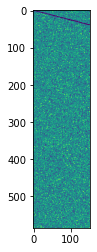

In [125]:
start_point = (start_x, start_y)  # (x, y)
end_point = (int(line_x_end), int(line_y_end))
print(end_point)
print(syn_img.shape)
# Draw the line
syn_img = (255*syn_img.T).astype(np.uint8)
#syn_img = (255*np.stack([syn_img.T]*3, axis=-1)).astype(np.uint8)
print(syn_img.shape)
plt.imshow(syn_img)

In [124]:

cv2.line(syn_img, start_point, end_point, color=(0, 0, 255), thickness=10)
cv2.line(syn_img, (0, 0), (500, 130), (0, 0, 255), 2)

img_rgb = cv2.cvtColor(syn_img, cv2.COLOR_BGR2RGB)

# Show the image
plt.imshow(img_rgb)
plt.show()

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'line'
> Overload resolution failed:
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'


In [100]:
start_point, end_point

((279, 153), (489, 0))

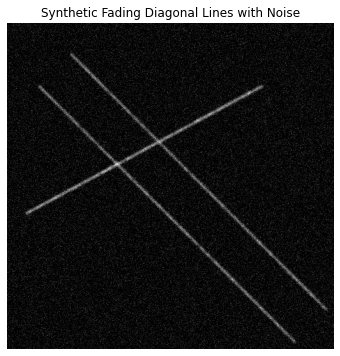

In [3]:
# Step 1: Create a blank black image
height, width = 512, 512
image = np.zeros((height, width), dtype=np.float32)  # float for smoother adding

# Step 2: Draw diagonal lines that fade in and out
lines = [
    ((50, 100), (450, 500)),
    ((100, 50), (500, 450)),
    ((30, 300), (400, 100)),
]

for start, end in lines:
    # Create points along the line
    num_points = 500
    x_values = np.linspace(start[0], end[0], num_points)
    y_values = np.linspace(start[1], end[1], num_points)

    for x, y in zip(x_values, y_values):
        # Random strength for fading (between 100 and 255)
        intensity = np.random.randint(100, 256)
        # Draw a small circle at each point with varying brightness
        cv2.circle(image, (int(x), int(y)), radius=1, color=float(intensity), thickness=-1)

# Step 3: Blur the image to smooth things out
blurred = cv2.GaussianBlur(image, (7, 7), sigmaX=2)

# Step 4: Add background noise
noise = np.random.normal(loc=0, scale=20, size=(height, width)).astype(np.float32)
noisy_image = blurred + noise

# Step 5: Clip values to 0-255 and convert to uint8
noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

# Step 6: Display
plt.figure(figsize=(6, 6))
plt.imshow(noisy_image, cmap='gray')
plt.title("Synthetic Fading Diagonal Lines with Noise")
plt.axis('off')
plt.show()


In [15]:
target_shape

(585, 153)